preproceso de datos para entrenar la red

En este caso no hay dataset etiquetado de faithful, por tanto crearé en datset descargando los datos de la página oficial del pack de texturas.<br>
[https://database.faithfulpack.net/packs/32x-Java/Experimental/Faithful%2032x%20-%201.21.1%20Experimental.zip]<br>
 assets/minecraft/textures/item guarda las imagenes con sus respectivos nombres de los objetos en formato png, por tanto la carpeta contiene las imagenes con las que generar y los promts de condicionamiento (nombre del archivo) de las imagenes.

## Datos

In [4]:
import os
from PIL import Image
import io
import pandas as pd
import matplotlib.pyplot as plt

# unificamos fondo a blanco para evitar problemas de formato de imagen (fondo vacío)
def dataset_from_folder(folder_path: str, image_exts={'.png'}, background_color=(255, 255, 255)):
    
    image_files = [
        f for f in os.listdir(folder_path)
        if os.path.splitext(f)[1].lower() in image_exts
    ]

    images, labels = [], []

    for filename in sorted(image_files):
        image_path = os.path.join(folder_path, filename)

        with Image.open(image_path) as im:
            # Convertir imágenes tipo paleta con transparencia
            if im.mode == "P":
                im = im.convert("RGBA")

            # Si tiene canal alfa → componer sobre fondo blanco
            if im.mode == "RGBA":
                bg = Image.new("RGB", im.size, background_color)
                bg.paste(im, mask=im.split()[-1])
                im = bg
            else:
                im = im.convert("RGB")

            # Convertir a bytes PNG
            buf = io.BytesIO()
            im.save(buf, format="PNG")

            # Guardar con el formato {'bytes': ...}
            images.append({"bytes": buf.getvalue()})

        # Etiqueta limpia
        label = os.path.splitext(filename)[0].replace("_", " ")
        labels.append(label)

    df = pd.DataFrame({
        "image": images,
        "label": labels
    })

    return df


Version 1.21.1 faithful32x32

In [6]:
version="1.21.1"
tam=32

items_folder = f"datos/item_{version}_{str(tam)}x{str(tam)}"
df = dataset_from_folder(items_folder)


In [7]:
df.head()

,image,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,acacia boat
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,acacia chest boat
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,acacia door
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,acacia hanging sign
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,acacia sign


In [8]:
df.shape

(604, 2)

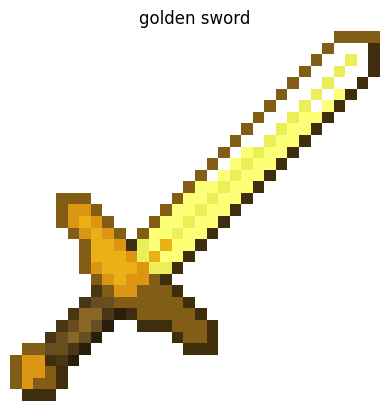

In [9]:
# visualización de una imagen con su etiqueta
def mostrar_imagen(row):
    image_bytes = row['image']['bytes']
    img = Image.open(io.BytesIO(image_bytes))

    plt.imshow(img)
    plt.axis("off")
    plt.title(row['label'])
    plt.show()

mostrar_imagen(df.iloc[300])


#### Guardar los datos en un parquet

In [10]:
df.to_parquet(f"datos/faithful_{version}_{str(tam)}.parquet")

### Inclusión de bloques

para la generación con lora vamos a considerar inlcuir los bloques + los items para hacer más grande nuestro dataset, como no es necesario entrenar el embedding de condicionamiento de texto, ya que usaremos un modelo preenetrenado que logre txt->img 

tenemos que limpiar los bloques (solo los que sean .png) ya que el resto de archivos define el movimiento del bloque (sacar los nombres de los que tengan una extension final que no sea .png)


In [11]:
version="1.21.1"
tam=32

block_folder = f"datos/block_{version}_{str(tam)}x{str(tam)}"

In [12]:
import os

archivos = os.listdir(block_folder)
no_png = [f for f in archivos if not f.lower().endswith(".png")]
block_to_drop=[i.split(".")[0] for i in no_png]
print(len(block_to_drop))


49


solo son 49 asi podemos permitirnos eliminar esos objetos

In [13]:
import os
from PIL import Image
import io
import pandas as pd

def dataset_from_folder_filtered(
    folder_path: str,
    forbidden_names: list,
    image_exts={'.png'},
    background_color=(255, 255, 255)
):
    # Listar SOLO archivos válidos
    image_files = []
    for f in os.listdir(folder_path):
        name_no_ext, ext = os.path.splitext(f)
        if ext.lower() in image_exts:
            # Excluir si su nombre esta en la lista
            if name_no_ext.lower() not in forbidden_names:
                image_files.append(f)

    images, labels = [], []

    for filename in sorted(image_files):
        image_path = os.path.join(folder_path, filename)

        with Image.open(image_path) as im:
            # Convertir imágenes tipo paleta con transparencia
            if im.mode == "P":
                im = im.convert("RGBA")

            # Si tiene canal alfa → componer sobre fondo blanco
            if im.mode == "RGBA":
                bg = Image.new("RGB", im.size, background_color)
                bg.paste(im, mask=im.split()[-1])
                im = bg
            else:
                im = im.convert("RGB")

            # Convertir a bytes PNG
            buf = io.BytesIO()
            im.save(buf, format="PNG")

            # Guardar con el formato {'bytes': ...}
            images.append({"bytes": buf.getvalue()})

        # Etiqueta limpia
        label = os.path.splitext(filename)[0].replace("_", " ")
        labels.append(label)

    df = pd.DataFrame({
        "image": images,
        "label": labels
    })

    return df


In [15]:
# crear el nuevo dataset
df_block=dataset_from_folder_filtered(block_folder,block_to_drop)
df_block = pd.concat([df_block,df],ignore_index=True)

In [17]:
df_block.shape

(1564, 2)

#### Guardar los datos en un parquet

In [18]:
df_block.to_parquet(f"datos/ib_faithful_{version}_{str(tam)}.parquet")